In [3]:
import cv2
import numpy as np
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
import imageio

In [4]:
def preprocess_image(image, mask, threshold=200):
    
    # Extract the inverted green channel
    inv_green_channel = 255 - image[:, :, 1]
    
    # Apply a 69x69 mean filter to compute the local average
    local_avg = cv2.blur(inv_green_channel, (69, 69))
    
    # Select regions with values greater than threshold
    bright_mask = inv_green_channel > threshold

    # Replace bright regions with the local average background
    inv_green_channel[bright_mask] = local_avg[bright_mask]
 
    # Subtract the local background and scale the gray levels from 0 to 1
    subtracted = inv_green_channel.astype(np.float32) - local_avg.astype(np.float32)
    subtracted_scaled = cv2.normalize(subtracted, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # Add a constant so that the mode gray level value is set to 0.5
    # This is an approximation using a histogram to find the mode
    hist, bins = np.histogram(subtracted_scaled.flatten(), 256, [0,1])
    mode = bins[np.argmax(hist)] 
    adjusted_image = subtracted_scaled + (0.5 - mode)
    
    adjusted_image = cv2.bitwise_and(adjusted_image, adjusted_image, mask=mask)
    
    return adjusted_image

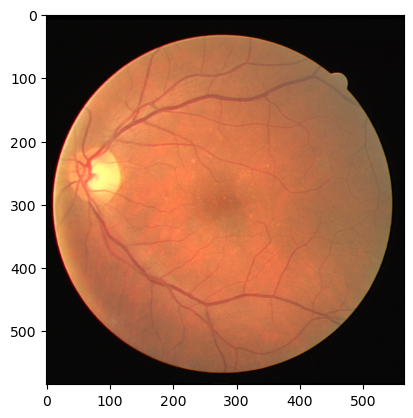

In [5]:
image = cv2.imread('../Drive/training/images/21_training.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

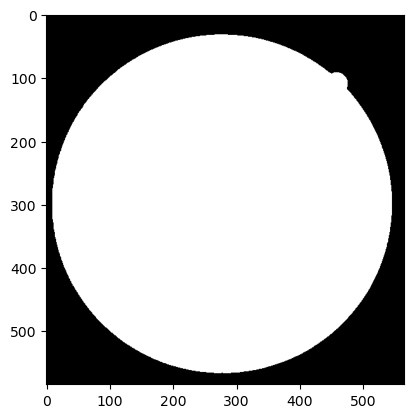

In [6]:
mask = imageio.mimread('../Drive/training/mask/21_training_mask.gif')[0]
plt.imshow(mask, cmap='gray')

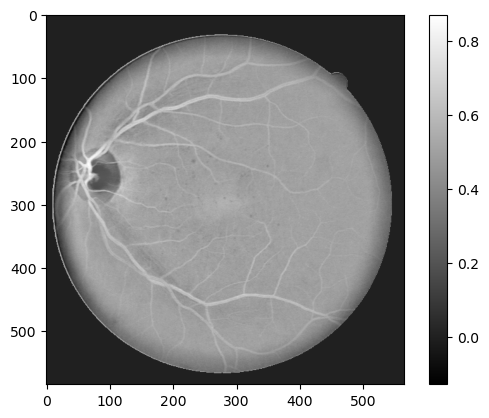

In [7]:
preprocessed_image = preprocess_image(image, mask)
plt.imshow(preprocessed_image, cmap='gray')
plt.colorbar()

In [8]:
def create_line_kernel(length, angle):

    # Create an empty black image
    kernel = np.zeros((length, length), dtype=np.float32)

    # Set the middle point
    mid = length // 2

    # Calculate end points of the line with the given angle
    radians = np.deg2rad(angle)
    x_end = int(round(mid + mid * np.cos(radians)))
    y_end = int(round(mid - mid * np.sin(radians)))

    # Draw the line on the kernel with white color (intensity 1)
    cv2.line(kernel, (mid, mid), (x_end, y_end), 1, thickness=1)

    # Normalize the kernel so that the sum is 1
    kernel /= np.sum(kernel)

    return kernel

In [9]:
def create_laplacian_kernel(size):
    # Ensure that the size is odd to have a central pixel
    if size % 2 == 0:
        raise ValueError("Size of the kernel must be odd")

    # Create an empty array with the given size
    kernel = np.zeros((size, size), dtype=np.float32)
    
    # Calculate the middle index
    mid = size // 2
    
    # Set the center pixel to the number of pixels minus one
    kernel[mid, mid] = (size * size) - 1
    
    # Set all other pixels to -1
    kernel -= 1
    
    return kernel

In [10]:
def line_detection(image):    
    scales = [3, 5, 7, 9, 11, 13, 15]
    angles = np.arange(0, 180, 10)
    responses = []

    # Compute local average gray-level Iavg(x, y)
    Iavg = cv2.blur(image, (15, 15))

    for s in scales:
        max_responses = np.zeros_like(image)
        for angle in angles:
#             kernel = create_laplacian_kernel(s)
            kernel = create_line_kernel(s, angle)
            response = cv2.filter2D(image, -1, kernel)
            max_responses = np.maximum(max_responses, response)
        Rs = max_responses - Iavg        
        Rs_rescaled = (Rs - np.mean(Rs)) / np.std(Rs)
        responses.append(Rs_rescaled * s)

    # Combine the responses with the original image
    R_combined = 1/64 * (np.sum(responses, axis=0) + image)

    # Scale the final output to range from 0 to 1
    R_final = cv2.normalize(R_combined, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return R_final

In [11]:
def otsu_post_processing(image):
    
    # Convert image to 8-bit
    image_8bit = cv2.convertScaleAbs(image, alpha=(255.0))
    
    # Apply Otsu's thresholding
    ret, _ = cv2.threshold(image_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Reduce threshold by 25%
    threshold = ret * 0.75
    
    # Binarize image with the increased threshold
    _, binarized_image = cv2.threshold(image_8bit, threshold, 255, cv2.THRESH_BINARY)
    
    # Remove very small objects to reduce noise and convert to uint8
    cleaned_image = remove_small_objects(binarized_image.astype(bool), min_size=100).astype(np.uint8) * 255
    
    return cleaned_image

In [12]:
def classify_pixels(line_detected_image, ground_truth):
    TP = np.logical_and(line_detected_image == 255, ground_truth == 255).astype(int) 
    FP = np.logical_and(line_detected_image == 255, ground_truth == 0).astype(int)
    FN = np.logical_and(line_detected_image == 0, ground_truth == 255).astype(int)
    TN = np.logical_and(line_detected_image == 0, ground_truth == 0).astype(int)
    
    comparison_image = np.zeros((*line_detected_image.shape, 3), dtype=np.uint8)
    comparison_image[TP == 1] = [0, 255, 0]
    comparison_image[FP == 1] = [255, 0, 0]
    comparison_image[FN == 1] = [0, 0, 255]
    
    eval_metrics = [TP, FP, FN, TN]
    
    return comparison_image, eval_metrics

(-0.5, 564.5, 583.5, -0.5)

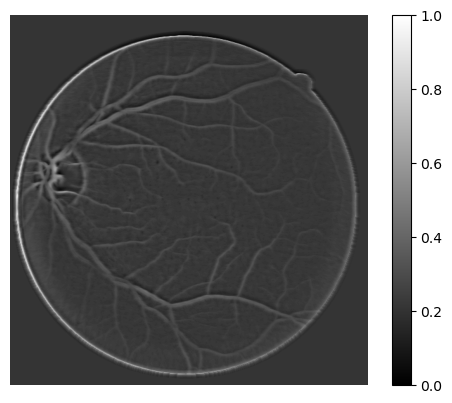

In [13]:
line_detected_image = line_detection(preprocessed_image)
plt.imshow(line_detected_image, cmap='gray')
plt.colorbar()
plt.axis('off')

(-0.5, 564.5, 583.5, -0.5)

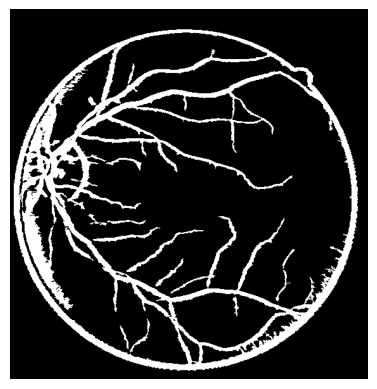

In [14]:
post_processed = otsu_post_processing(line_detected_image)
plt.imshow(post_processed, cmap='gray')
plt.axis('off')

(-0.5, 564.5, 583.5, -0.5)

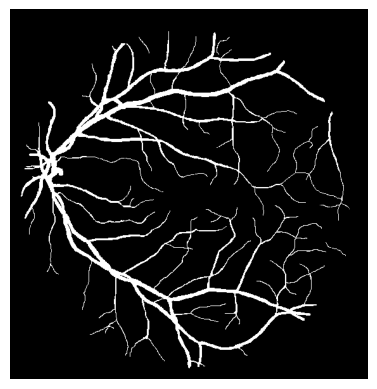

In [15]:
ground_truth_image = imageio.mimread('../Drive/training/1st_manual/21_manual1.gif')[0]
plt.imshow(ground_truth_image, cmap='gray')
plt.axis('off')

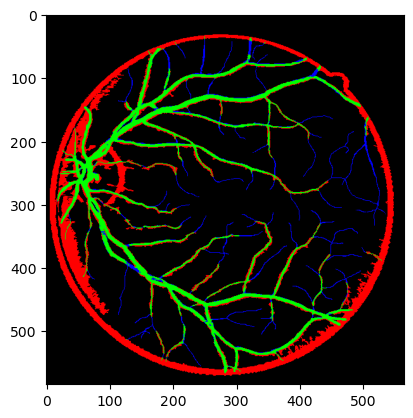

In [16]:
eval_metrics = []
classified_image, eval_metrics = classify_pixels(post_processed, ground_truth_image)
plt.imshow(classified_image)

In [17]:
# Save confidence map for hybrid algorithm
np.save('line_detec_confidence_map.npy', line_detected_image)

In [19]:
TP = np.sum(eval_metrics[0])
FP = np.sum(eval_metrics[1])
FN = np.sum(eval_metrics[2])
TN = np.sum(eval_metrics[3])

# Calculate accuracy
accuracy = (TP + TN) / (TP + FP + FN + TN)

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8923
Precision: 0.3902
Recall: 0.7847
